In [55]:
from pyspark.sql import SparkSession
spark = SparkSession.builder \
    .appName("BTC_USD_Analysis") \
    .getOrCreate()

from pyspark.sql.functions import avg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#File Paths, make sure to change them for your computer

In [12]:
df_yearly = spark.read.option("header", True).csv(
    "/storage/work/eml6069/DS410/DS410_Final/btcusd_annual.csv"
)

df_monthly = spark.read.option("header", True).csv(
    "/storage/work/eml6069/DS410/DS410_Final/btcusd_monthly.csv"
)

In [13]:
df_yearly.columns

['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume']

In [26]:
from pyspark.sql.functions import regexp_replace, to_timestamp, to_date, year, month

#Remove timezone info
df_monthly_clean = df_monthly.withColumn(
    "Timestamp_clean",
    regexp_replace("Timestamp", r"\+00:00$", "")
)

#Convert to timestamp
df_monthly_clean = df_monthly_clean.withColumn(
    "ts",
    to_timestamp("Timestamp_clean", "yyyy-MM-dd HH:mm:ss")
)

#Extract date, year, month
df_monthly_clean = df_monthly_clean.withColumn("date", to_date("ts")) \
                                   .withColumn("year", year("date")) \
                                   .withColumn("month", month("date"))

df_monthly_clean.show(5)


+--------------------+----+----+----+-----+--------------+----------+----+-----+-------------------+-------------------+
|           Timestamp|Open|High| Low|Close|        Volume|      date|year|month|    Timestamp_clean|                 ts|
+--------------------+----+----+----+-----+--------------+----------+----+-----+-------------------+-------------------+
|2012-01-31 00:00:...|4.58|7.38| 3.8| 5.55| 2012.25343589|2012-01-31|2012|    1|2012-01-31 00:00:00|2012-01-31 00:00:00|
|2012-02-29 00:00:...|5.55| 6.5| 3.8| 4.99|  4761.6090813|2012-02-29|2012|    2|2012-02-29 00:00:00|2012-02-29 00:00:00|
|2012-03-31 00:00:...|4.99|5.44|4.54| 4.92| 9049.62628191|2012-03-31|2012|    3|2012-03-31 00:00:00|2012-03-31 00:00:00|
|2012-04-30 00:00:...|4.92|5.43|4.69|  5.0|16484.16777244|2012-04-30|2012|    4|2012-04-30 00:00:00|2012-04-30 00:00:00|
|2012-05-31 00:00:...| 5.0|5.15|4.86| 5.14|18520.10380101|2012-05-31|2012|    5|2012-05-31 00:00:00|2012-05-31 00:00:00|
+--------------------+----+----+

In [28]:
df_monthly_clean.columns

['Timestamp',
 'Open',
 'High',
 'Low',
 'Close',
 'Volume',
 'date',
 'year',
 'month',
 'Timestamp_clean',
 'ts']

In [31]:
df_monthly_clean.coalesce(1).write.option("header", True).mode("overwrite").csv("bitcoin_monthly_single_csv")

In [51]:
df_visualize = spark.read.option("header", True).csv(
    "/storage/work/eml6069/DS410/DS410_Final/bitcoin_monthly_single_csv/clean_monthlybtc.csv"
)

In [52]:
pandas_2012 = df_visualize.orderBy("month").toPandas()
print(pandas_2012.columns)

Index(['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'date', 'year',
       'month', 'Timestamp_clean', 'ts'],
      dtype='object')


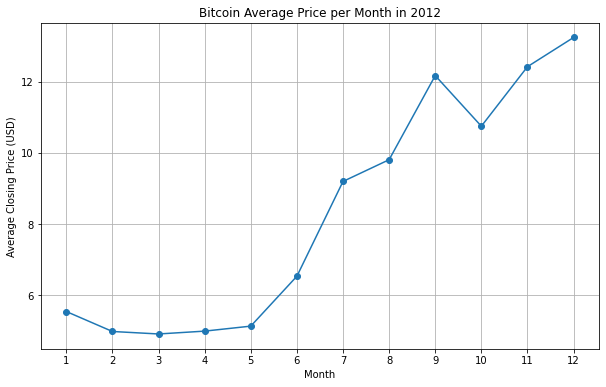

In [56]:
pandas_2012['avg_close'] = pandas_2012['avg_close'].astype(float)

#Sort by month
pandas_2012 = pandas_2012.sort_values('month')

#Plot
plt.figure(figsize=(10,6))
plt.plot(np.array(pandas_2012['month']), np.array(pandas_2012['avg_close']),
         marker='o', linestyle='-')
plt.title("Bitcoin Average Price per Month in 2012")
plt.xlabel("Month")
plt.ylabel("Average Closing Price (USD)")
plt.xticks(range(1,13))  # show all months
plt.grid(True)
plt.show()
